## IMDB Dataset: CNN Classifier 

Using CNN model to develop a sentiment classifier for the IMDB dataset

#### Load dependencies

In [2]:
import tensorflow
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding
from tensorflow.keras.layers import SpatialDropout1D, Conv1D, GlobalMaxPooling1D 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import pandas as pd

#### Set hyperparameters

In [3]:
# Model Train
epochs = 10
batch_size = 128

# vector-space embedding: 
n_dim = 64
n_unique_words = 5000 
max_review_length = 100
pad_type = trunc_type = 'pre'
drop_embed = 0.2 

# CNN architecture:
n_conv = 256 
k_conv = 3 

# Dense layer architecture: 
n_dense = 256
dropout = 0.2

#### Load data

In [4]:
(x_train, y_train), (x_valid, y_valid) = imdb.load_data(num_words=n_unique_words) 

17465344/17464789 [==============================] - 0s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:155: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

#### Date Pre-Processing 

In [5]:
x_train = pad_sequences(x_train, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)
x_valid = pad_sequences(x_valid, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)

#### CNN Design Architecture

In [6]:
model = Sequential()
model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length)) 
model.add(SpatialDropout1D(drop_embed))
model.add(Conv1D(n_conv, k_conv, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(n_dense, activation='relu'))
model.add(Dropout(dropout))
model.add(Dense(1, activation='sigmoid'))

In [7]:
model.summary() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 64)           320000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 100, 64)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 98, 256)           49408     
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               65792     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2

#### Configure model

In [8]:
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])

#### Train Model

In [9]:
es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=0.01, patience=4, verbose=1, restore_best_weights=True)

In [10]:
model_log = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_valid, y_valid), callbacks=[es])

Epoch 1/10
196/196 [==============================] - 27s 130ms/step - loss: 0.5078 - accuracy: 0.7266 - val_loss: 0.3954 - val_accuracy: 0.8172
Epoch 2/10
196/196 [==============================] - 25s 129ms/step - loss: 0.3060 - accuracy: 0.8684 - val_loss: 0.3190 - val_accuracy: 0.8593
Epoch 3/10
196/196 [==============================] - 25s 130ms/step - loss: 0.2335 - accuracy: 0.9082 - val_loss: 0.3201 - val_accuracy: 0.8596
Epoch 4/10
196/196 [==============================] - 25s 130ms/step - loss: 0.1730 - accuracy: 0.9355 - val_loss: 0.3469 - val_accuracy: 0.8585
Epoch 5/10
196/196 [==============================] - 25s 130ms/step - loss: 0.1238 - accuracy: 0.9566 - val_loss: 0.4557 - val_accuracy: 0.8406
Epoch 6/10
196/196 [==============================] - 26s 131ms/step - loss: 0.0800 - accuracy: 0.9729 - val_loss: 0.4421 - val_accuracy: 0.8540
Restoring model weights from the end of the best epoch.
Epoch 00006: early stopping


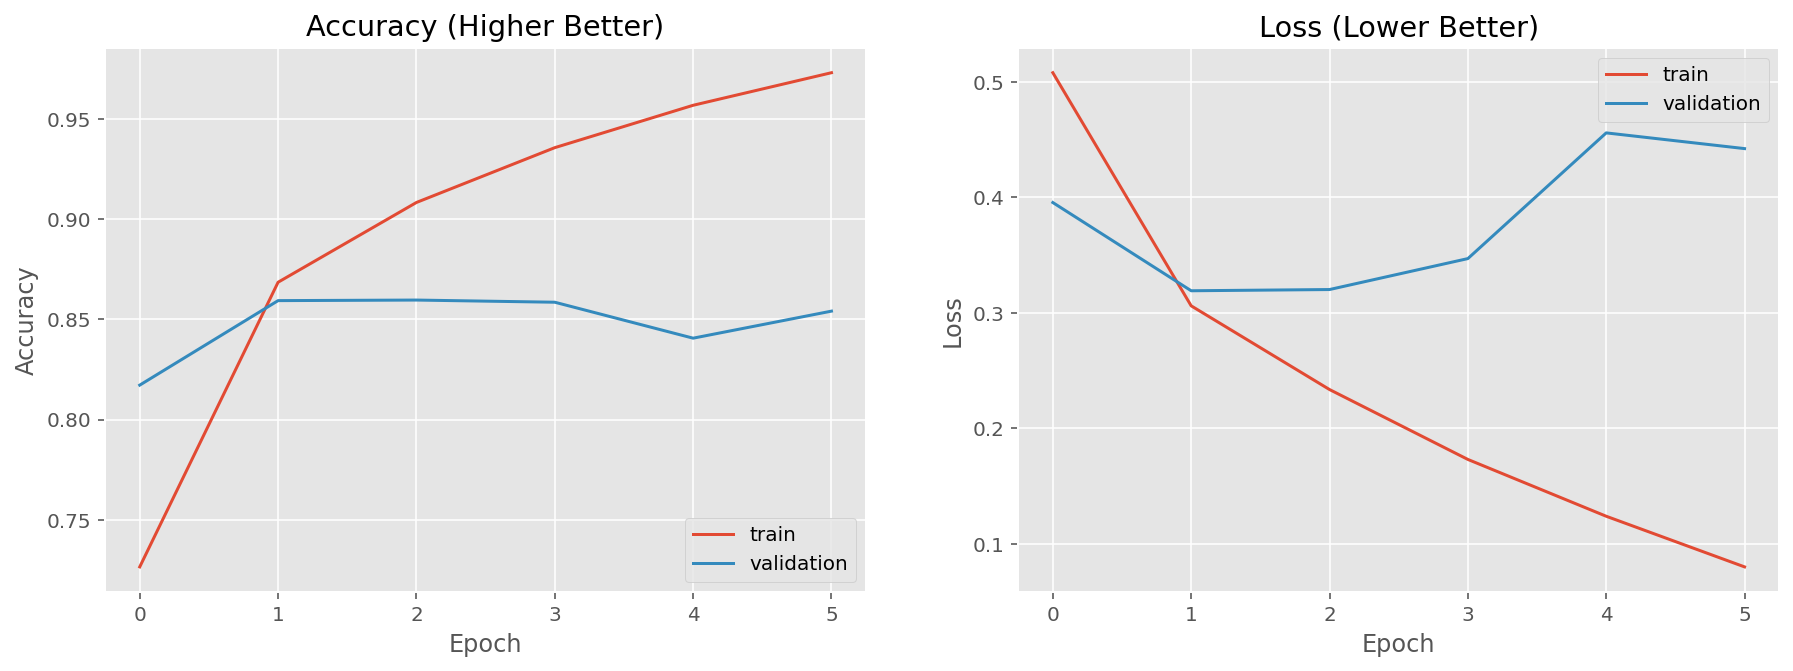

In [11]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))

ax1.plot(model_log.history['accuracy'])
ax1.plot(model_log.history['val_accuracy'])
ax1.set_title('Accuracy (Higher Better)')
ax1.set(xlabel='Epoch', ylabel='Accuracy')
ax1.legend(['train', 'validation'], loc='lower right')

ax2.plot(model_log.history['loss'])
ax2.plot(model_log.history['val_loss'])
ax2.set_title('Loss (Lower Better)')
ax2.set(xlabel='Epoch', ylabel='Loss')
ax2.legend(['train', 'validation'], loc='upper right')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

In [16]:
model.save("IMDBCNNv4model.h5")

#### Evaluate

In [17]:
score = model.evaluate(x_valid, y_valid, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.3190143406391144
Test accuracy: 0.859279990196228


In [18]:
y_hat = model.predict(x_valid)
y_hat1 = pd.DataFrame(data=y_hat)
y_hat1[0]=y_hat1[0].apply(lambda a:0 if a<=0.5 else 1)
y_hat2 = y_hat1[0]

In [19]:
print(confusion_matrix(y_valid, y_hat2))
print(classification_report(y_valid,y_hat2))

[[10738  1762]
 [ 1756 10744]]
              precision    recall  f1-score   support

           0       0.86      0.86      0.86     12500
           1       0.86      0.86      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000

